# MMMI Oversight Script


POPULATION MODEL

**TODO**: Fix steady state computation

**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.

CONFIGURATION FOR EXPERIMENTS

**TODO**: Easy testing of multiple memory parameters  ($p_1$,$\Delta_1$,$p_2$,$\Delta_2$ on the FinanceModel)
**TODO**: Varying the attention rate
**TODO**: Varying the dividend rate


OTHER

**TODO**: Refactor main simulation loop to have 'days' on the outer loop

**TODO**: Reduce NL logging/warning in the notebook.

**TODO**: `requirements.txt`

**TODO**: Begin automated tests

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.

**TODO**: Refactor code from AttentionSimulation to AgentPopulation as appropriate.



In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)
import hark_portfolio_agents as hpa
import logging
import math
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Portfolio Consumption Model

The AttentionSimulation uses the Portfolio Consumption model from HARK.
The agent's resources unfold according to the following transition equations.

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
$\eta$ | ~Dist | Shock | c | --
$\theta$ | ~Dist | Shock | c | --
$\psi$ | ~Dist | Shock | c | --
$\hat{R}$ | $$\hat{R} = \alpha * R + (1 - \alpha) * R$$ | Update | c | --
b | $b_{t} = a_{t-1} \hat{R}$ | Update | c | --
p | $p_{t}=p_{t-1}\psi_{t}$ | Update | c | --
y | $y_{t} = p_{t}\theta _{t}$ | Update | c | --
m | $m_{t} = b_{t} + y_{t}$ | Update | c | --
c | c | Control | c | U(c)
a | $a_{t} = m_{t} - c_{t}$ | Update | portshare | --
$\alpha$ | $\alpha$ | Control | portshare | 0


## Initialize the Simulation

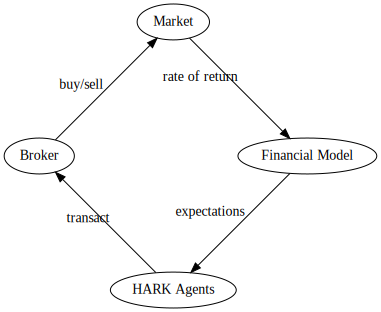

In [2]:
import graphviz as gv

dot = gv.Digraph(engine='circo')

dot.node('A', 'HARK Agents')
dot.node('B', 'Broker')
dot.node('M', 'Market')
dot.node('F', 'Financial Model')

dot.edge('A', 'B', label="transact")
dot.edge('B', 'M', label="buy/sell")
dot.edge('M', 'F', label="rate of return")
dot.edge('F', 'A', label="expectations")

dot

The AttentionSimulation class operates the "oversight code" with respect to four other simulation elements.

* HARK Agents - The consumers that earn, consume, and invest in the risky asset. When they have new targets for allocating their assets, they transact with the broker to buy or sell assets. They do this at the current 'market price'.
* Broker - Aggregates the consumer 
* Market - The PyNetLogo model of the Market, which takes the aggregate consumer demand and returns a rate of return.
* Financial Model - Computes the expectations of the risky asset from the rates of return history.

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [3]:
import math

dist_params = {
    'CRRA' : {'bot' : 2, 'top' : 10, 'n' : 2}, # Chosen for "interesting" results
    'DiscFac' : {'bot' : 0.936, 'top' : 0.978, 'n' : 2} # from CSTW "MPC" results
}

# Get empirical data from Sabelhaus and Song
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
    'TranShkStd' : [ssvp['TranShkStd'][idx_40] / 2],  # Adjust non-multiplicative shock to quarterly
    'PermShkStd' : [ssvp['PermShkStd'][idx_40] ** 0.25]
}

## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

See `hpa.run_market`.

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

Accounting functions.

## Run the main loop



In [4]:
pop = hpa.AgentPopulation(agent_parameters, dist_params, 20)

max_q = 15
tolerance = .01

def run_simulation(pop, q = None, r = 1, market = None):
    # Initialize the financial model
    fm = hpa.FinanceModel()

    fm.calculate_risky_expectations()
    agent_parameters.update(fm.risky_expectations())

    # Initialize the population model
    pop.init_simulation()
    

    if q is None:
        ## Run simulation until consumers reach convergence on normalized market resources
        attsim = hpa.AttentionSimulation(pop, fm, r = r, market = market)
        cs_pre = pop.class_stats()
        
        quarter = 0
        converged = False
        while not converged and quarter <= max_q:
            print(f"Q:{quarter}")
            attsim.simulate(quarters = 1, start = quarter == 0)
            converged = (abs((1 - cs_pre / pop.class_stats(store=False))['aLvl']['mean']) < tolerance).all()
            quarter = quarter + 1
    else:
        attsim = hpa.AttentionSimulation(pop, fm, q = q, r = r)
        attsim.simulate()
    
    return attsim

In [ ]:
attsim = run_simulation(pop, r = 15, market = hpa.MockMarket())
attsim.report()
attsim.report_class_stats()

/home/sb/projects/econ-ark/HARK/HARK/core.py:871: RuntimeWarning: invalid value encountered in add
  self.history[var_name] = np.empty((self.T_sim, self.AgentCount)) + np.nan


Q:0
Q-0
Q-0:R-0
Buy/Sell Limit: (0, 0)
ror: -0.02012907242025693
Q-0:D-0. 5 macro-updates.
Q-0:D-1. 0 macro-updates.
Q-0:D-2. 2 macro-updates.
Q-0:D-3. 1 macro-updates.
Q-0:R-1
Buy/Sell Limit: (5, 0)
ror: -0.020711004271141586
Q-0:D-4. 1 macro-updates.
Q-0:D-5. 2 macro-updates.
Q-0:D-6. 2 macro-updates.
Q-0:D-7. 2 macro-updates.
Q-0:R-2
Buy/Sell Limit: (2, 0)
ror: 0.030073283562103537
Q-0:D-8. 1 macro-updates.
Q-0:D-9. 2 macro-updates.
Q-0:D-10. 2 macro-updates.
Q-0:D-11. 1 macro-updates.
Q-0:R-3
Buy/Sell Limit: (0, 1)
ror: -0.006370901780188752
Q-0:D-12. 3 macro-updates.
Q-0:D-13. 2 macro-updates.
Q-0:D-14. 3 macro-updates.
Q-0:D-15. 1 macro-updates.
Q-0:R-4
Buy/Sell Limit: (10, 0)
ror: 0.0006890768788580543
Q-0:D-16. 1 macro-updates.
Q-0:D-17. 0 macro-updates.
Q-0:D-18. 2 macro-updates.
Q-0:D-19. 1 macro-updates.
Q-0:R-5
Buy/Sell Limit: (9, 0)
ror: 0.01904670747943318
Q-0:D-20. 1 macro-updates.
Q-0:D-21. 1 macro-updates.
Q-0:D-22. 1 macro-updates.
Q-0:D-23. 0 macro-updates.
Q-0:R-6
B

Q-0:D-18. 2 macro-updates.
Q-0:D-19. 1 macro-updates.
Q-0:R-5
Buy/Sell Limit: (2, 11)
ror: 0.012298348253200975
Q-0:D-20. 1 macro-updates.
Q-0:D-21. 1 macro-updates.
Q-0:D-22. 1 macro-updates.
Q-0:D-23. 0 macro-updates.
Q-0:R-6
Buy/Sell Limit: (15, 9)
ror: 0.032518754333316045
Q-0:D-24. 0 macro-updates.
Q-0:D-25. 2 macro-updates.
Q-0:D-26. 0 macro-updates.
Q-0:D-27. 2 macro-updates.
Q-0:R-7
Buy/Sell Limit: (0, 42)
ror: -0.005484879937625871
Q-0:D-28. 0 macro-updates.
Q-0:D-29. 0 macro-updates.
Q-0:D-30. 2 macro-updates.
Q-0:D-31. 3 macro-updates.
Q-0:R-8
Buy/Sell Limit: (1, 38)
ror: 0.008812827286114282
Q-0:D-32. 2 macro-updates.
Q-0:D-33. 1 macro-updates.
Q-0:D-34. 0 macro-updates.
Q-0:D-35. 2 macro-updates.
Q-0:R-9
Buy/Sell Limit: (3, 2)
ror: 0.02521400658160823
Q-0:D-36. 1 macro-updates.
Q-0:D-37. 1 macro-updates.
Q-0:D-38. 0 macro-updates.
Q-0:D-39. 1 macro-updates.
Q-0:R-10
Buy/Sell Limit: (0, 34)
ror: -0.00677712656467706
Q-0:D-40. 3 macro-updates.
Q-0:D-41. 2 macro-updates.
Q-0:

Buy/Sell Limit: (0, 116)
ror: 0.008021685444737473
Q-0:D-36. 1 macro-updates.
Q-0:D-37. 1 macro-updates.
Q-0:D-38. 0 macro-updates.
Q-0:D-39. 1 macro-updates.
Q-0:R-10
Buy/Sell Limit: (20, 104)
ror: -0.02510498052495926
Q-0:D-40. 3 macro-updates.
Q-0:D-41. 2 macro-updates.
Q-0:D-42. 4 macro-updates.
Q-0:D-43. 1 macro-updates.
Q-0:R-11
Buy/Sell Limit: (0, 106)
ror: -0.007108626803597935
Q-0:D-44. 1 macro-updates.
Q-0:D-45. 2 macro-updates.
Q-0:D-46. 2 macro-updates.
Q-0:D-47. 1 macro-updates.
Q-0:R-12
Buy/Sell Limit: (25, 127)
ror: 0.008159012970516853
Q-0:D-48. 1 macro-updates.
Q-0:D-49. 1 macro-updates.
Q-0:D-50. 1 macro-updates.
Q-0:D-51. 2 macro-updates.
Q-0:R-13
Buy/Sell Limit: (0, 90)
ror: 0.005204357443247774
Q-0:D-52. 1 macro-updates.
Q-0:D-53. 1 macro-updates.
Q-0:D-54. 0 macro-updates.
Q-0:D-55. 1 macro-updates.
Q-0:R-14
Buy/Sell Limit: (0, 58)
ror: -0.005510587827264131
Q-0:D-56. 1 macro-updates.
Q-0:D-57. 1 macro-updates.
Q-0:D-58. 0 macro-updates.
Q-0:D-59. 0 macro-updates.

Q-0:D-55. 1 macro-updates.
Q-0:R-14
Buy/Sell Limit: (0, 16)
ror: 0.019230759695448015
Q-0:D-56. 1 macro-updates.
Q-0:D-57. 1 macro-updates.
Q-0:D-58. 0 macro-updates.
Q-0:D-59. 0 macro-updates.
Q:10
Q-0
Q-0:R-0
Buy/Sell Limit: (0, 15)
ror: 0.0210389636011652
Q-0:D-0. 5 macro-updates.
Q-0:D-1. 0 macro-updates.
Q-0:D-2. 2 macro-updates.
Q-0:D-3. 1 macro-updates.
Q-0:R-1
Buy/Sell Limit: (0, 14)
ror: 0.005647893010138658
Q-0:D-4. 1 macro-updates.
Q-0:D-5. 2 macro-updates.
Q-0:D-6. 2 macro-updates.
Q-0:D-7. 2 macro-updates.
Q-0:R-2
Buy/Sell Limit: (0, 14)
ror: -0.011461405189264069
Q-0:D-8. 1 macro-updates.
Q-0:D-9. 2 macro-updates.
Q-0:D-10. 2 macro-updates.
Q-0:D-11. 1 macro-updates.
Q-0:R-3
Buy/Sell Limit: (0, 21)
ror: 0.01281170366201612
Q-0:D-12. 3 macro-updates.
Q-0:D-13. 2 macro-updates.
Q-0:D-14. 3 macro-updates.
Q-0:D-15. 1 macro-updates.
Q-0:R-4
Buy/Sell Limit: (0, 19)
ror: -0.015532143277153656
Q-0:D-16. 1 macro-updates.
Q-0:D-17. 0 macro-updates.
Q-0:D-18. 2 macro-updates.
Q-0:D

Q-0:D-12. 3 macro-updates.
Q-0:D-13. 2 macro-updates.
Q-0:D-14. 3 macro-updates.
Q-0:D-15. 1 macro-updates.
Q-0:R-4
Buy/Sell Limit: (1, 1)
ror: 0.011075431497533659
Q-0:D-16. 1 macro-updates.
Q-0:D-17. 0 macro-updates.
Q-0:D-18. 2 macro-updates.
Q-0:D-19. 1 macro-updates.
Q-0:R-5
Buy/Sell Limit: (1, 0)
ror: -0.0023531120344956634
Q-0:D-20. 1 macro-updates.
Q-0:D-21. 1 macro-updates.
Q-0:D-22. 1 macro-updates.
Q-0:D-23. 0 macro-updates.
Q-0:R-6
Buy/Sell Limit: (1, 0)
ror: 0.0059754265748979225
Q-0:D-24. 0 macro-updates.
Q-0:D-25. 2 macro-updates.
Q-0:D-26. 0 macro-updates.
Q-0:D-27. 2 macro-updates.
Q-0:R-7
Buy/Sell Limit: (1, 1)
ror: -0.011978933950658124
Q-0:D-28. 0 macro-updates.
Q-0:D-29. 0 macro-updates.
Q-0:D-30. 2 macro-updates.
Q-0:D-31. 3 macro-updates.
Q-0:R-8
Buy/Sell Limit: (3, 0)
ror: -0.017657875937781144
Q-0:D-32. 2 macro-updates.
Q-0:D-33. 1 macro-updates.
Q-0:D-34. 0 macro-updates.
Q-0:D-35. 2 macro-updates.
Q-0:R-9
Buy/Sell Limit: (4, 0)
ror: -0.0038706789637928465
Q-0

In [ ]:
pop.class_stats()

In [ ]:
attsim.history['class_stats'][-200:]

In [ ]:
#import multiprocessing

#inputs = range(3)

#pool = multiprocessing.Pool()
#records = pool.map(run_simulation, inputs)
#pool.close()